In [57]:
# Data preparation script: data_preparation.py

# Импорт необходимых библиотек
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

# Конфигурация параметров
BASE_DIR = 'data'
RAW_DIR = os.path.join(BASE_DIR, 'raw')
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed')
AUGMENTED_DIR = os.path.join(BASE_DIR, 'augmented')
IMG_SIZE = (224, 224)
TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_STATE = 42
BATCH_SIZE = 32

# Создание директорий
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(AUGMENTED_DIR, exist_ok=True)
for subdir in ['train', 'val', 'test']:
    os.makedirs(os.path.join(PROCESSED_DIR, subdir), exist_ok=True)
    os.makedirs(os.path.join(AUGMENTED_DIR, subdir), exist_ok=True)

print("Директории созданы!")


Директории созданы!


 - Bacteria: 569 изображений
 - Early_blight: 1000 изображений
 - Fungi: 748 изображений
 - Healthy: 353 изображений
 - Late_blight: 1000 изображений
 - Nematode: 68 изображений
 - Pest: 611 изображений
 - Phytopthora: 347 изображений
 - Virus: 532 изображений


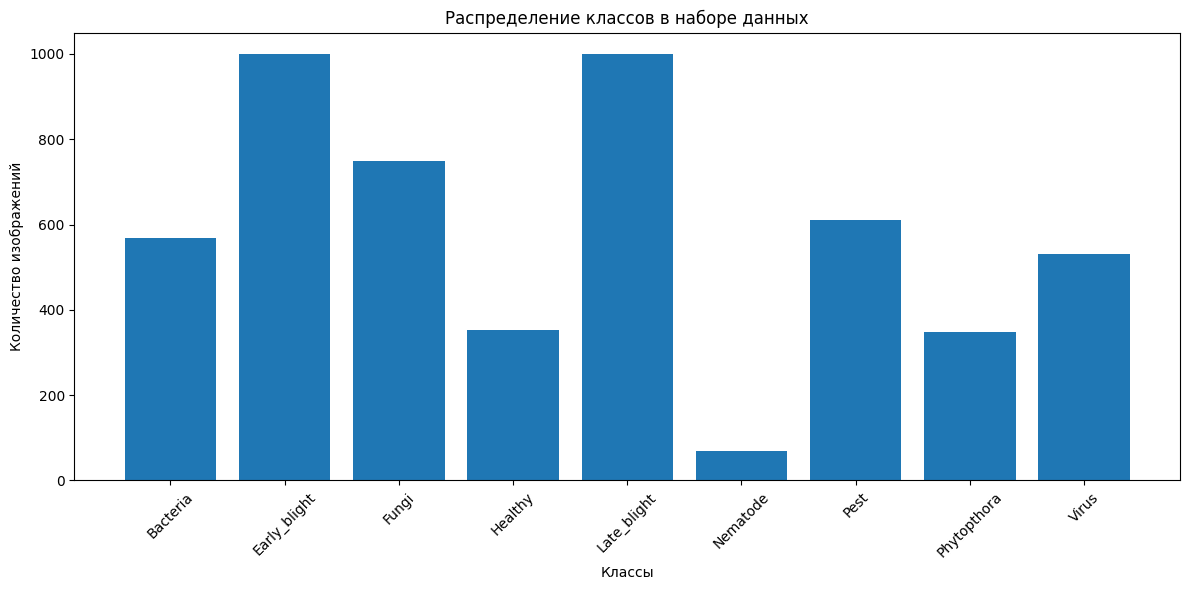

In [58]:
# Анализ распределения классов
classes = sorted([d for d in os.listdir(RAW_DIR) if os.path.isdir(os.path.join(RAW_DIR, d))])
class_distribution = {}

plt.figure(figsize=(12, 6))
for class_name in classes:
    class_path = os.path.join(RAW_DIR, class_name)
    num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    class_distribution[class_name] = num_images
    print(f" - {class_name}: {num_images} изображений")

# Визуализация распределения
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Распределение классов в наборе данных')
plt.xlabel('Классы')
plt.ylabel('Количество изображений')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DIR, 'class_distribution.png'))
plt.show()

In [59]:
# Создание DataFrame с метаданными
data = []
for class_name in classes:
    class_path = os.path.join(RAW_DIR, class_name)
    for img_file in os.listdir(class_path):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(class_path, img_file)
            data.append({
                'image_path': img_path,
                'class': class_name,
                'file_name': img_file
            })

df = pd.DataFrame(data)
print(f"Создан DataFrame с {len(df)} записями")
df.head()

Создан DataFrame с 5228 записями


,image_path,class,file_name
0,data\raw\Bacteria\1692332350433.jpg,Bacteria,1692332350433.jpg
1,data\raw\Bacteria\1692332350457.jpg,Bacteria,1692332350457.jpg
2,data\raw\Bacteria\1692333303178.jpg,Bacteria,1692333303178.jpg
3,data\raw\Bacteria\1692333631862.jpg,Bacteria,1692333631862.jpg
4,data\raw\Bacteria\1692333631989.jpg,Bacteria,1692333631989.jpg


In [60]:
# Упрощенная функция предобработки изображений
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Не удалось загрузить изображение: {img_path}")
    
    # Простая конвертация и ресайз
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    
    # Не нормализуем здесь - это сделает генератор
    return img


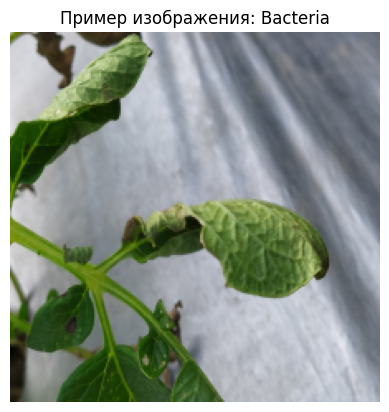

Размеры выборок:
Train: 3658 (70.0%)
Val: 785 (15.0%)
Test: 785 (15.0%)


In [61]:
# Тестирование функции предобработки
sample_img = preprocess_image(df.iloc[0]['image_path'])
plt.imshow(sample_img)
plt.title(f"Пример изображения: {df.iloc[0]['class']}")
plt.axis('off')
plt.show()

# Разделение данных на train/val/test
train_val_df, test_df = train_test_split(
    df, 
    test_size=TEST_SIZE, 
    stratify=df['class'],
    random_state=RANDOM_STATE
)

train_df, val_df = train_test_split(
    train_val_df, 
    test_size=VAL_SIZE/(1-TEST_SIZE),
    stratify=train_val_df['class'],
    random_state=RANDOM_STATE
)

print(f"Размеры выборок:")
print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Val: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

In [62]:

# Сохранение метаданных
train_df.to_csv(os.path.join(PROCESSED_DIR, 'train_metadata.csv'), index=False)
val_df.to_csv(os.path.join(PROCESSED_DIR, 'val_metadata.csv'), index=False)
test_df.to_csv(os.path.join(PROCESSED_DIR, 'test_metadata.csv'), index=False)

# Организация изображений по директориям
def organize_images(df, subset):
    for _, row in df.iterrows():
        class_dir = os.path.join(PROCESSED_DIR, subset, row['class'])
        os.makedirs(class_dir, exist_ok=True)
        dest_path = os.path.join(class_dir, row['file_name'])
        if not os.path.exists(dest_path):
            shutil.copy(row['image_path'], dest_path)

organize_images(train_df, 'train')
organize_images(val_df, 'val')
organize_images(test_df, 'test')

print("Изображения организованы по директориям!")

Изображения организованы по директориям!


In [63]:
# Создание генераторов данных (без предобработки - она будет в model_development)
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.02,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.95, 1.05],
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Создание генераторов
train_generator = train_datagen.flow_from_directory(
    os.path.join(PROCESSED_DIR, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(PROCESSED_DIR, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(PROCESSED_DIR, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Сохранение соответствия классов и индексов
class_indices = train_generator.class_indices
class_indices_path = os.path.join(PROCESSED_DIR, 'class_indices.json')
with open(class_indices_path, 'w') as f:
    json.dump(class_indices, f)

print("\nГенераторы созданы:")
print(f"Train: {train_generator.samples} изображений")
print(f"Validation: {val_generator.samples} изображений")
print(f"Test: {test_generator.samples} изображений")

Found 3658 images belonging to 9 classes.
Found 785 images belonging to 9 classes.
Found 785 images belonging to 9 classes.

Генераторы созданы:
Train: 3658 изображений
Validation: 785 изображений
Test: 785 изображений


Размер батча изображений: (32, 224, 224, 3)
Размер батча меток: (32, 9)


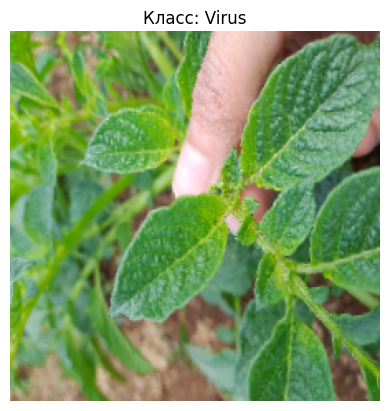

In [64]:
# Проверка работы генератора
images, labels = next(train_generator)

print("Размер батча изображений:", images.shape)
print("Размер батча меток:", labels.shape)

# Визуализация первого изображения в батче
plt.imshow(images[0].astype('uint8'))
class_idx = np.argmax(labels[0])
class_name = list(train_generator.class_indices.keys())[class_idx]
plt.title(f"Класс: {class_name}")
plt.axis('off')
plt.show()